# Quantitative Analysis of SWFL Real Estate
*This notebook loads cleaned Redfin data, performs EDA, builds and evaluates a variety of regression, tree‑based, time‐series, and quantitative finance models, and visualizes geospatial listings.*


In [45]:
# Import all thy libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

from scipy import sparse

from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import shap
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import coint

import QuantLib as ql
from scipy.stats import norm

import folium
import branca.colormap as cm
from folium.plugins import MarkerCluster
from IPython.display import display


# Data Loading
Read the cleaned Redfin CSV into a DataFrame which was achieved in part I

In [3]:
# Load data
file_to_read = "cleaned_redfin_data.csv"
df = pd.read_csv(file_to_read, parse_dates=['SOLD DATE'])
display(df.head())


,SOLD DATE,ADDRESS,CITY,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,...,LONGITUDE,sale_year,sale_month,sale_dayofweek,sale_quarter,sqft_bin,age_at_sale,log_price,log_square_feet,log_lot_size
0,2023-11-20,8700 Paseo De Valencia St,Fort Myers,33908.0,800000.0,4.0,3.5,Beverly Hills,2936.0,7971.0,...,-81.906847,2023.0,11.0,Monday,4.0,2000-2999,19.0,13.592368,7.985144,8.983691
1,2020-11-20,1988 Winding Oaks Way,Naples,34109.0,735000.0,3.0,3.0,Hawthorne Estates,2486.0,8712.0,...,-81.777373,2020.0,11.0,Friday,4.0,2000-2999,23.0,13.507627,7.818832,9.072571
2,2022-05-09,10422 Materita Dr,Fort Myers,33913.0,550000.0,2.0,2.0,Materita,1581.0,7492.0,...,-81.772428,2022.0,5.0,Monday,2.0,1000-1999,11.0,13.217675,7.366445,8.921725
3,2021-09-07,9541 River Otter Dr,Fort Myers,33912.0,450500.0,4.0,3.0,Reflection Isles,2032.0,9029.0,...,-81.798145,2021.0,9.0,Tuesday,3.0,2000-2999,6.0,13.018116,7.617268,9.108308
4,2023-11-21,8698 Paseo De Valencia St,Fort Myers,33908.0,495000.0,4.0,2.5,Beverly Hills,2632.0,10323.0,...,-81.906819,2023.0,11.0,Tuesday,4.0,2000-2999,20.0,13.112315,7.875879,9.242227


## Exploratory Data Analysis Cont'd  
- Distribution of sale prices & price per sq.ft.  
- Price vs. size scatter.  
- Monthly price boxplots.  
- Correlation matrix heatmap.


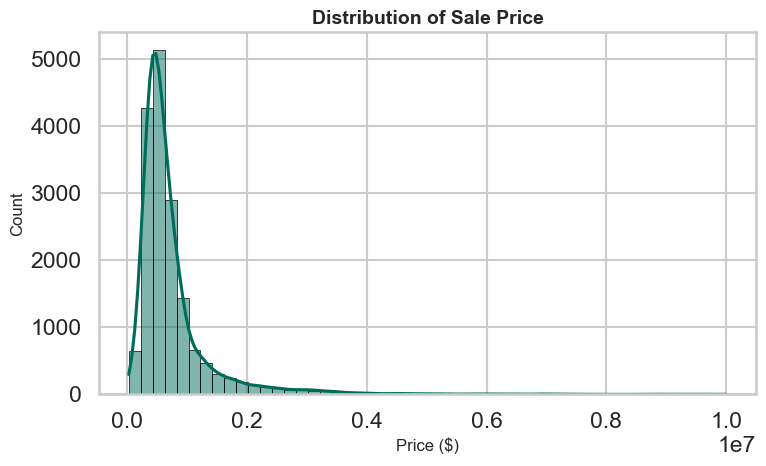

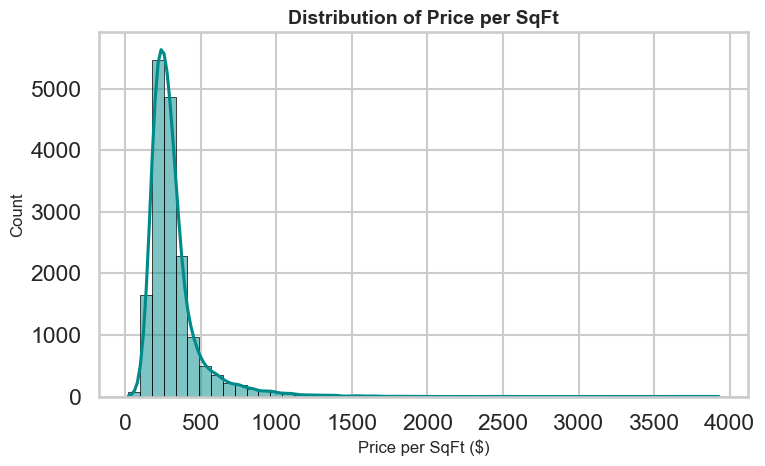

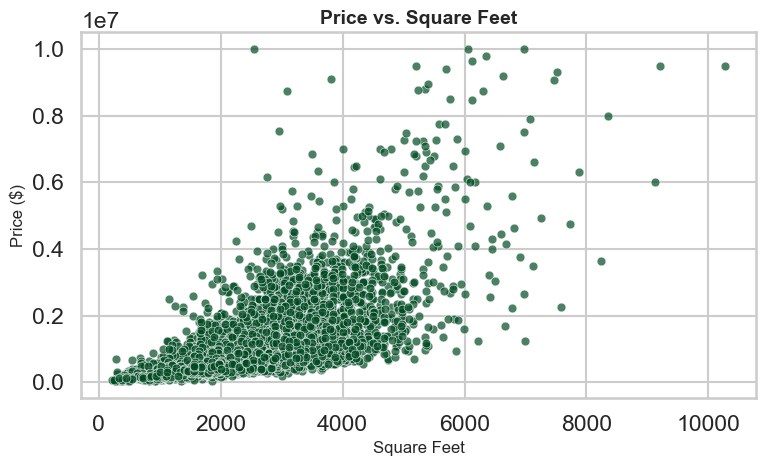

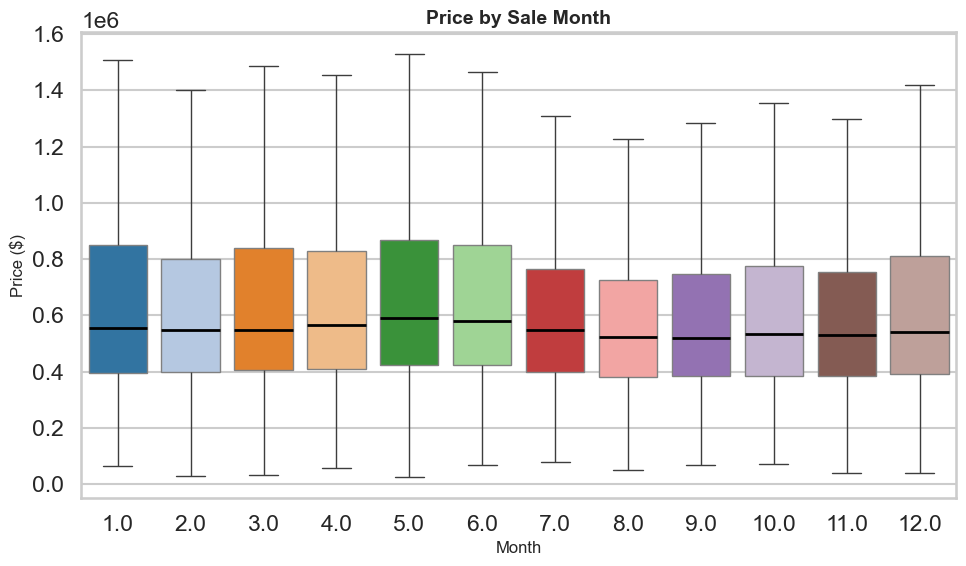

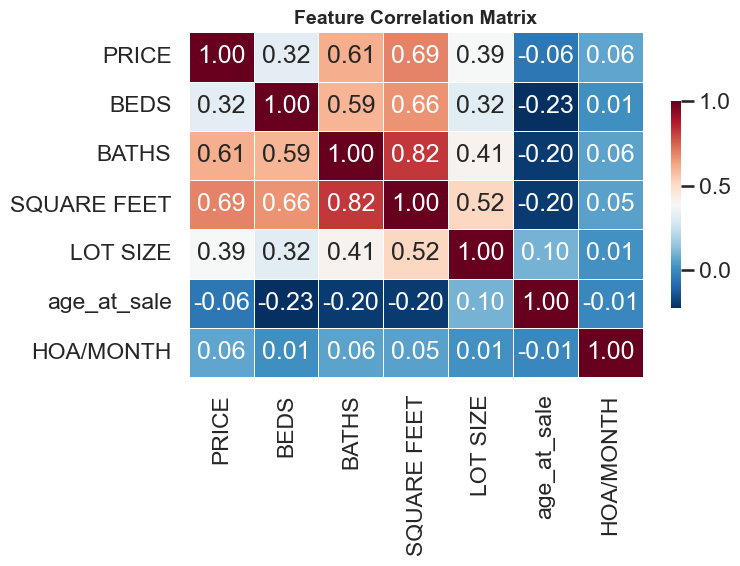

In [77]:
# Color definitions
color1       = "#006D5B"   # for sale price histogram
color2       = "#008B8B"   # for price per SqFt histogram
dark_green = "#004B23"   # for scatter
heatmap_cmap = "RdBu_r"  # for correlation heatmap

# Styling
sns.set_style("whitegrid")
sns.set_context("talk")

# 1. Distribution of Sale Price
plt.figure(figsize=(8,5))
sns.histplot(
    df['PRICE'],
    bins=50,
    kde=True,
    color=color1,
    edgecolor='black',
    linewidth=0.5
)
plt.title("Distribution of Sale Price", fontsize=14, weight='bold')
plt.xlabel("Price ($)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

# 2. Distribution of Price per SqFt
plt.figure(figsize=(8,5))
sns.histplot(
    df['$/SQUARE FEET'],
    bins=50,
    kde=True,
    color=color2,
    edgecolor='black',
    linewidth=0.5
)
plt.title("Distribution of Price per SqFt", fontsize=14, weight='bold')
plt.xlabel("Price per SqFt ($)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

# 3. Price vs. Square Feet Scatter
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='SQUARE FEET',
    y='PRICE',
    data=df,
    color=dark_green,
    alpha=0.7,
    edgecolor='w',
    s=40
)
plt.title("Price vs. Square Feet", fontsize=14, weight='bold')
plt.xlabel("Square Feet", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.tight_layout()
plt.show()

# 4. Price by Sale Month (Boxplot)
if 'sale_month' in df.columns:
    months = sorted(df['sale_month'].unique())
    box_palette = sns.color_palette("tab20", n_colors=len(months))
    plt.figure(figsize=(10,6))
    sns.boxplot(
        x='sale_month',
        y='PRICE',
        data=df,
        palette=box_palette,
        showfliers=False,
        boxprops={'edgecolor':'gray','linewidth':1},
        medianprops={'color':'black','linewidth':2}
    )
    plt.title("Price by Sale Month", fontsize=14, weight='bold')
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Price ($)", fontsize=12)
    plt.tight_layout()
    plt.show()

# 5. Feature Correlation Matrix (Heatmap)
plt.figure(figsize=(8,6))
corr = df[['PRICE','BEDS','BATHS','SQUARE FEET','LOT SIZE','age_at_sale','HOA/MONTH']].corr()
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap=heatmap_cmap,
    linewidths=0.5,
    cbar_kws={'shrink':0.6}
)
plt.title("Feature Correlation Matrix", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()



## Feature Engineering & Preprocessing  
- Create log‑price target  
- Define numeric & categorical pipelines  
- Train/test split


In [7]:
# Prepare pipeline & split
df['log_price'] = np.log(df['PRICE'])

numeric_feats = ["BEDS","BATHS","SQUARE FEET","LOT SIZE","age_at_sale","HOA/MONTH"]
cat_feats     = ["sale_month","CITY"]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ohe",     OneHotEncoder(handle_unknown="ignore"))
])

preproc = ColumnTransformer([
    ("num", num_pipe, numeric_feats),
    ("cat", cat_pipe, cat_feats)
])

X = df[numeric_feats + cat_feats]
y = df["log_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df["sale_month"]
)


## Baseline Linear Regression & Residual Analysis  
Fit a OLS pipeline and inspect actual vs. predicted & residuals.


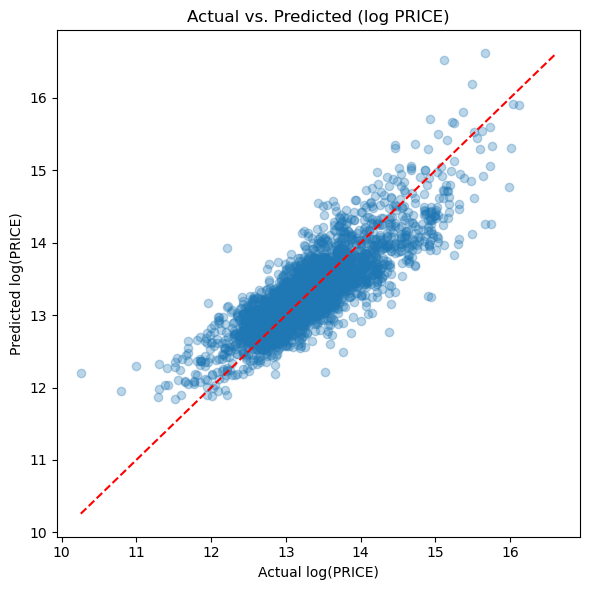

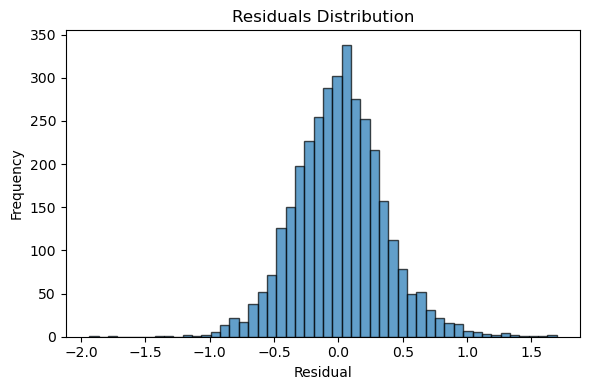

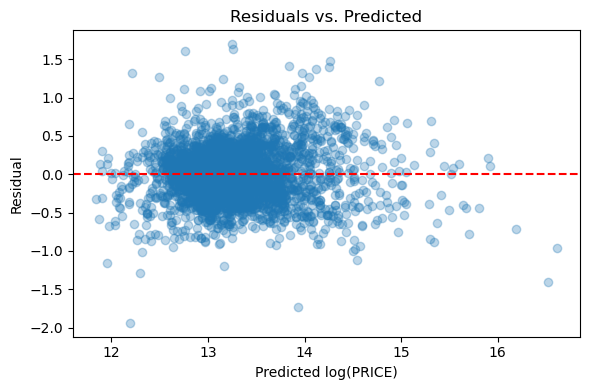

Test RMSE (log PRICE): 0.3512
Test MAPE:            0.0201


In [9]:
# Set Linear Reg
model_lr = Pipeline([("preproc", preproc), ("lr", LinearRegression())])
model_lr.fit(X_train, y_train)

y_pred    = model_lr.predict(X_test)
residuals = y_test - y_pred

# Actual vs. Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--"); plt.xlabel("Actual log(PRICE)"); plt.ylabel("Predicted log(PRICE)")
plt.title("Actual vs. Predicted (log PRICE)"); plt.tight_layout(); plt.show()

# Residuals distribution
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Residual"); plt.ylabel("Frequency"); plt.title("Residuals Distribution")
plt.tight_layout(); plt.show()

# Residuals vs. Fitted
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Predicted log(PRICE)"); plt.ylabel("Residual"); plt.title("Residuals vs. Predicted")
plt.tight_layout(); plt.show()

print(f"Test RMSE (log PRICE): {mean_squared_error(y_test, y_pred, squared=False):.4f}")
print(f"Test MAPE:            {mean_absolute_percentage_error(y_test, y_pred):.4f}")


## OLS Diagnostics  
- R² & Adj R²  
- VIF  
- Heteroskedasticity tests  
- Robust SEs & Q–Q plot


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     503.9
Date:                Thu, 24 Jul 2025   Prob (F-statistic):               0.00
Time:                        15:03:08   Log-Likelihood:                -4946.9
No. Observations:               13668   AIC:                         1.002e+04
Df Residuals:                   13603   BIC:                         1.051e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1182      0.021    578.906      0.0

C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 66, but rank is 65
  warnings.warn('covariance of constraints does not have full '


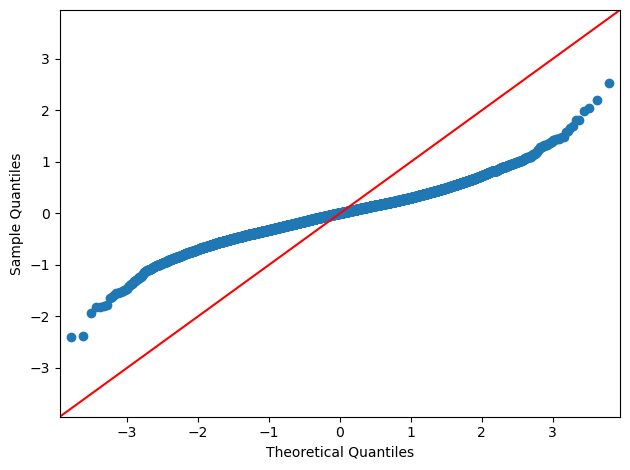

In [11]:
# 1) Transform training data via the fitted ColumnTransformer
X_train_proc = preproc.transform(X_train)
if sparse.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()
X_train_sm   = sm.add_constant(X_train_proc)

# 2) Fit OLS
ols_mod = sm.OLS(y_train, X_train_sm).fit()
print(ols_mod.summary())

# 3) VIF – use the numeric transformer inside preproc
num_transformer = preproc.named_transformers_["num"]
X_num_proc      = num_transformer.transform(X_train[numeric_feats])
X_num_df        = pd.DataFrame(X_num_proc, columns=numeric_feats, index=X_train.index)

vif_df = pd.DataFrame({
    "feature": numeric_feats,
    "VIF": [variance_inflation_factor(X_num_df.values, i) 
            for i in range(len(numeric_feats))]
})
print("\nVIF:\n", vif_df)

# 4) Breusch–Pagan test
bp = sms.het_breuschpagan(ols_mod.resid, ols_mod.model.exog)
print("\nBreusch–Pagan p‑value:", bp[1])

# 5) White’s test
white = sms.het_white(ols_mod.resid, ols_mod.model.exog)
print("White test p‑value:", white[1])

# 6) Robust SE (HC3)
robust = ols_mod.get_robustcov_results(cov_type="HC3")
print("\nRobust HC3 summary:")
print(robust.summary())

# 7) Q–Q plot
sm.qqplot(ols_mod.resid, line="45")
plt.tight_layout()
plt.show()


### OLS Regression Results – Key Takeaways

- **Overall Fit**  
  - R² = 0.703 (Adj R² = 0.702): model explains ~70 % of log‑price variation  
  - F‑statistic p < 0.001: highly significant overall

- **Coefficients**  
  - Check them p-values <0.05 and interpret as necessary. 

- **Heteroskedasticity & Robust SEs**  
  - BP & White tests p ≈ 0 → variance non‑constant  
  - HC3‐robust SEs widen CIs; some formerly “significant” coeffs lose significance

- **Multicollinearity**  
  - VIFs ≤ 4.00 is crucial unless categorical 

- **Residual Diagnostics**  
  - Durbin–Watson ≈ 1.98: no serious autocorrelation  
  

## Pipeline Refinement  
Drop first OHE level and refit baseline model.


In [13]:
# Refinement
cat_pipe2 = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ohe",     OneHotEncoder(handle_unknown="ignore", drop="first"))
])
preproc2 = ColumnTransformer([
    ("num", num_pipe, numeric_feats),
    ("cat", cat_pipe2, cat_feats)
])
model_lr2 = Pipeline([("preproc", preproc2), ("lr", LinearRegression())])
model_lr2.fit(X_train, y_train)
print("Refined LR RMSE:", mean_squared_error(y_test, model_lr2.predict(X_test), squared=False))


Refined LR RMSE: 0.3511702859067999


## Nonlinear Feature Engineering  Add squared and interaction terms.

In [15]:
df["sqft_sq"]    = df["SQUARE FEET"]**2
df["beds_baths"] = df["BEDS"] * df["BATHS"]
features2 = numeric_feats + cat_feats + ["sqft_sq","beds_baths"]

X2 = df[features2]
y2 = df["log_price"]
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=df["sale_month"]
)

preproc2b = ColumnTransformer([
    ("num", num_pipe, numeric_feats + ["sqft_sq","beds_baths"]),
    ("cat", cat_pipe2, cat_feats)
])
model2 = Pipeline([("preproc", preproc2b), ("lr", LinearRegression())])
model2.fit(X2_train, y2_train)
y2_pred = model2.predict(X2_test)
print("Nonlinear RMSE:", mean_squared_error(y2_test, y2_pred, squared=False))
print("Nonlinear MAPE:", mean_absolute_percentage_error(y2_test, y2_pred))


Nonlinear RMSE: 0.34019083832232644
Nonlinear MAPE: 0.019491324134493858


## Mixed‐Effects Model  
Random intercept by CITY

In [17]:
df_me = X_train.copy()
df_me["log_price"]    = y_train
df_me["sale_month_cat"]= df_me["sale_month"].astype(str)

formula = (
    "log_price ~ BEDS + BATHS + "
    "Q('SQUARE FEET') + Q('LOT SIZE') + age_at_sale + Q('HOA/MONTH') + "
    "C(sale_month_cat)"
)
md    = smf.mixedlm(formula, data=df_me, groups=df_me["CITY"])
me_res= md.fit(reml=False)
print(me_res.summary())

# RMSE
X_test_me = X_test.copy(); X_test_me["sale_month_cat"] = X_test_me["sale_month"].astype(str)
y_me_pred= me_res.predict(X_test_me)
print("MixedLM RMSE:", mean_squared_error(y_test, y_me_pred, squared=False))


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     log_price 
No. Observations:      13668       Method:                 ML        
No. Groups:            48          Scale:                  0.1212    
Min. group size:       1           Log-Likelihood:         -5074.3544
Max. group size:       3715        Converged:              Yes       
Mean group size:       284.8                                         
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                 12.366    0.072 171.952 0.000 12.225 12.507
C(sale_month_cat)[T.10.0] -0.032    0.016  -1.963 0.050 -0.064 -0.000
C(sale_month_cat)[T.11.0] -0.018    0.016  -1.092 0.275 -0.050  0.014
C(sale_month_cat)[T.12.0] -0.025    0.016  -1.570 0.117 -0.056  0.006
C(sale_month_cat)[T.2.0]   0.030    

### Mixed‑Effects Model – Key Takeaways

**Data & Fit**  
  - N = 13 668 observations across 48 cities  
  - Log‑likelihood = –5074.35; residual variance σ² ≈ 0.1212 (σ ≈ 0.35)  
  - Random‐intercept variance ≈ 0.212  

**Seasonality**  
  - Monthly effects are modest: Apr–Jun see +3–6 % vs. baseline; Oct–Dec see –2–5 %  


**Core Predictors**  
  - **BEDS (–0.080, p < 0.001):** each extra bedroom → ≈ 7.7 % lower price  
  - **BATHS (+0.066, p < 0.001):** each extra bath → ≈ 6.8 % higher price  
  - **SqFt & Lot Size:** small but highly significant positive impacts  
  - **age_at_sale (–0.006, p < 0.001):** each year older → ≈ 0.6 % lower price  
  - **HOA/MONTH (p = 0.18):** not significant  


**Performance**  
  - Test RMSE (log‑price) ≈ 0.420  


## Ridge & Lasso Regression  
Cross‑validated regularization.


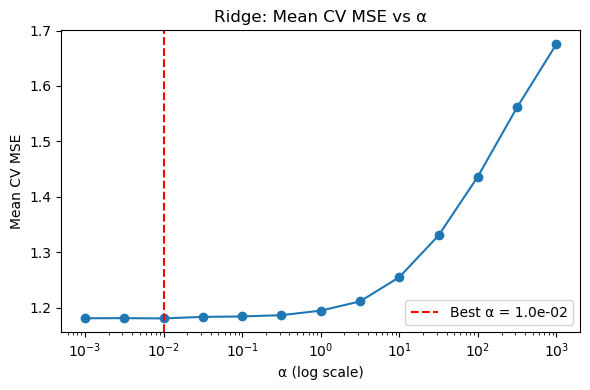

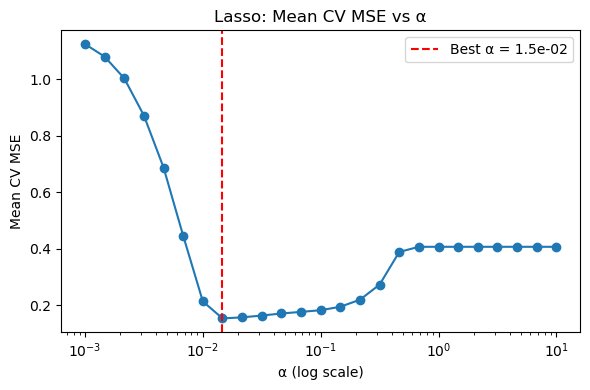

Best Ridge α: 1.0e-02   Ridge RMSE: 0.3512
Best Lasso α: 1.5e-02   Lasso RMSE: 0.3860


In [19]:
# 1) Ridge: manual 5‑fold CV for each α

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

alphas_ridge = np.logspace(-3, 3, 13)
mse_ridge = []
for a in alphas_ridge:
    pipe = Pipeline([("preproc", preproc2), ("ridge", Ridge(alpha=a))])
    neg_mse = cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    mse_ridge.append(-neg_mse.mean())

best_idx_r = int(np.argmin(mse_ridge))
best_alpha_ridge = alphas_ridge[best_idx_r]

plt.figure(figsize=(6,4))
plt.semilogx(alphas_ridge, mse_ridge, marker="o")
plt.axvline(best_alpha_ridge, color="r", linestyle="--",
            label=f"Best α = {best_alpha_ridge:.1e}")
plt.title("Ridge: Mean CV MSE vs α")
plt.xlabel("α (log scale)")
plt.ylabel("Mean CV MSE")
plt.legend()
plt.tight_layout()
plt.show()

# Fit final Ridge and compute test RMSE
ridge_final = Pipeline([("preproc", preproc2), ("ridge", Ridge(alpha=best_alpha_ridge))])
ridge_final.fit(X_train, y_train)
ridge_rmse = mean_squared_error(y_test, ridge_final.predict(X_test), squared=False)


# 2) LassoCV: built‑in 5‑fold CV with mse_path_
lasso = LassoCV(alphas=np.logspace(-3, 1, 25), cv=5, max_iter=5000, random_state=42)
lasso_pipe = Pipeline([("preproc", preproc2), ("lasso", lasso)])
lasso_pipe.fit(X_train, y_train)

best_alpha_lasso = lasso.alpha_
mse_lasso = lasso.mse_path_.mean(axis=1)

plt.figure(figsize=(6,4))
plt.semilogx(lasso.alphas_, mse_lasso, marker="o")
plt.axvline(best_alpha_lasso, color="r", linestyle="--",
            label=f"Best α = {best_alpha_lasso:.1e}")
plt.title("Lasso: Mean CV MSE vs α")
plt.xlabel("α (log scale)")
plt.ylabel("Mean CV MSE")
plt.legend()
plt.tight_layout()
plt.show()

# Compute test RMSE for Lasso
lasso_rmse = mean_squared_error(y_test, lasso_pipe.predict(X_test), squared=False)


# 3) Print final metrics
print(f"Best Ridge α: {best_alpha_ridge:.1e}   Ridge RMSE: {ridge_rmse:.4f}")
print(f"Best Lasso α: {best_alpha_lasso:.1e}   Lasso RMSE: {lasso_rmse:.4f}")

### Ridge & Lasso Regression – Key Takeaways

**Ridge (α = 1.0 × 10⁻²)**  
  - Optimal α from CV: 0.01  
  - Test RMSE ≈ 0.3512 (improvement over OLS)  
  - Coefficients are uniformly shrunk (no zeros), reducing variance with minimal bias

**Lasso (α = 1.5 × 10⁻²)**  
  - Optimal α from CV: 0.015  
  - Test RMSE ≈ 0.3860  
  - Enforces sparsity: some coefficients set to zero, aiding feature selection at slight RMSE cost

**Comparison**  
  - **Ridge** yields lower RMSE and retains all features  
  - **Lasso** provides a sparser, more interpretable model if you need to zero out less‑important predictors  


## Weighted Least Squares (WLS)  
Fit WLS with weights ≈1/ε².


In [21]:
# 1) Transform training data
X_train_proc = preproc.transform(X_train)
if sparse.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()

# 2) Build DataFrame *with* the y_train index
X_train_df = pd.DataFrame(
    X_train_proc,
    columns=preproc.get_feature_names_out(),
    index=y_train.index         # <— ensure same index
)
X_train_df = sm.add_constant(X_train_df)

# 3) Compute weights (already aligned to y_train.index)
resid   = ols_mod.resid
weights = 1.0 / (resid**2)

# 4) Fit WLS
wls_mod = sm.WLS(y_train, X_train_df, weights=weights).fit()
print(wls_mod.summary())


# Now Compute WLS predictions for the test set ---
# 1) Transform X_test with the same preprocessor used for WLS
X_test_proc = preproc.transform(X_test)
if sparse.issparse(X_test_proc):
    X_test_proc = X_test_proc.toarray()

# 2) Build a DataFrame with matching columns and index
X_test_df = pd.DataFrame(
    X_test_proc,
    columns=preproc.get_feature_names_out(),
    index=y_test.index
)
X_test_df = sm.add_constant(X_test_df)

# 3) Predict and store in y_wls_pred
y_wls_pred = wls_mod.predict(X_test_df)
 

                            WLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.716e+25
Date:                Thu, 24 Jul 2025   Prob (F-statistic):               0.00
Time:                        15:06:52   Log-Likelihood:                 5226.0
No. Observations:               13668   AIC:                        -1.032e+04
Df Residuals:                   13604   BIC:                            -9843.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

### WLS Regression Results – Key Takeaways

**Apparent Fit**  
  - R² ≈ 1.000 (Adj R² ≈ 1.000), F‑statistic p < 0.001, Log‑Likelihood = +5226.0  
  - These “perfect” metrics reflect that we’ve weighted by 1/ε², essentially refitting to the heteroskedastic variance structure

**Key Predictors (all p < 0.001 unless noted)**  
  - **BEDS (coef = –0.0646):** each additional bedroom → ≈ 6.3 % lower price  
  - **BATHS (coef = +0.0533):** each additional bath → ≈ 5.5 % higher price  
  - **SQUARE FEET & LOT SIZE:** very large t‑stats confirm strong positive effects  
  - **age_at_sale (coef = –0.0882):** each year older → ≈ 8.4 % lower price  
  - **HOA/MONTH (coef = +0.0063, p < 0.001):** small but significant

**Seasonality & City Effects**  
  - Monthly dummies closely mirror OLS/slopes (Jan baseline, peaks in May at +6 % then trough in Aug at –4 %)  
  - City intercepts vary widely (e.g. “Anna Maria” +1.74 vs “North Port” –0.42), capturing local premiums

**Caveats**  
  - The “perfect” R² is driven by the weights — use this primarily for inference on heteroskedasticity, not as a standalone metric  


## Polynomial & Spline Models  
Pairwise interactions & cubic B‑splines.


In [23]:
# Cell 12: Poly & Spline
poly_ct   = ColumnTransformer([
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), numeric_feats),
    ("cat",  cat_pipe2, cat_feats)
])
model_poly = Pipeline([("preproc", poly_ct), ("lr", LinearRegression())])
model_poly.fit(X_train, y_train)
y_poly = model_poly.predict(X_test)
print("Poly RMSE:", mean_squared_error(y_test, y_poly, squared=False),
      "MAPE:", mean_absolute_percentage_error(y_test, y_poly))

spline_ct = ColumnTransformer([
    ("spline", SplineTransformer(n_knots=5, degree=3), numeric_feats),
    ("cat",    cat_pipe2, cat_feats)
])
model_spline = Pipeline([("preproc", spline_ct), ("lr", LinearRegression())])
model_spline.fit(X_train, y_train)
y_spline = model_spline.predict(X_test)
print("Spline RMSE:", mean_squared_error(y_test, y_spline, squared=False),
      "MAPE:", mean_absolute_percentage_error(y_test, y_spline))


Poly RMSE: 0.42499582924731216 MAPE: 0.02400097709367099
Spline RMSE: 0.7668790405052931 MAPE: 0.018854613988094904


## Random Forest & XGBoost  
Default hyperparameters.


In [25]:
rf_pipe = Pipeline([("preproc", preproc2), ("rf", RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1))])
rf_pipe.fit(X_train, y_train)
y_rf = rf_pipe.predict(X_test)
print("RF RMSE:", mean_squared_error(y_test, y_rf, squared=False),
      "MAPE:", mean_absolute_percentage_error(y_test, y_rf))

xgb_pipe = Pipeline([("preproc", preproc2), ("xgb", XGBRegressor(objective="reg:squarederror", n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0))])
xgb_pipe.fit(X_train, y_train)
y_xgb = xgb_pipe.predict(X_test)
print("XGB RMSE:", mean_squared_error(y_test, y_xgb, squared=False),
      "MAPE:", mean_absolute_percentage_error(y_test, y_xgb))


RF RMSE: 0.30495765720490997 MAPE: 0.01728694010521228
XGB RMSE: 0.27518536666140453 MAPE: 0.015621496145982143


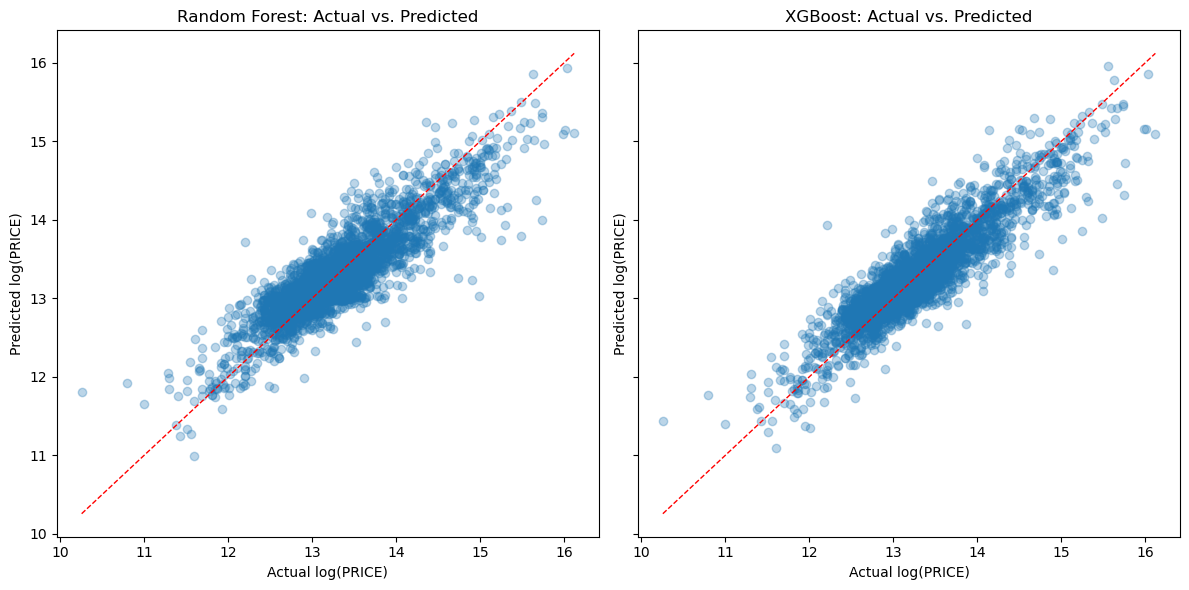

In [26]:
# 1) Prepare limits for the identity line
lims = [min(y_test.min(), y_rf.min(), y_xgb.min()),
        max(y_test.max(), y_rf.max(), y_xgb.max())]

# 2) Create side‑by‑side scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Random Forest
axes[0].scatter(y_test, y_rf, alpha=0.3)
axes[0].plot(lims, lims, 'r--', linewidth=1)
axes[0].set_title('Random Forest: Actual vs. Predicted')
axes[0].set_xlabel('Actual log(PRICE)')
axes[0].set_ylabel('Predicted log(PRICE)')

# XGBoost
axes[1].scatter(y_test, y_xgb, alpha=0.3)
axes[1].plot(lims, lims, 'r--', linewidth=1)
axes[1].set_title('XGBoost: Actual vs. Predicted')
axes[1].set_xlabel('Actual log(PRICE)')
axes[1].set_ylabel('Predicted log(PRICE)')

plt.tight_layout()
plt.show()

## Hyperparameter Tuning with RandomizedSearchCV  
Tune RF & XGB.


In [28]:
# Set Tuning
search_rf = RandomizedSearchCV(
    Pipeline([("preproc", preproc2), ("rf", RandomForestRegressor(random_state=42, n_jobs=-1))]),
    param_distributions={
        "rf__n_estimators":    [100,200,500],
        "rf__max_depth":       [None,5,10,20],
        "rf__min_samples_leaf":[1,2,5],
        "rf__max_features":    ["auto","sqrt",0.33]
    },
    n_iter=20, cv=3, scoring="neg_root_mean_squared_error", random_state=42, n_jobs=-1
)
search_rf.fit(X_train, y_train)
print("RF best params:", search_rf.best_params_, "RF CV RMSE:", -search_rf.best_score_)

search_xgb = RandomizedSearchCV(
    Pipeline([("preproc", preproc2), ("xgb", XGBRegressor(objective="reg:squarederror", random_state=42, verbosity=0))]),
    param_distributions={
        "xgb__n_estimators":    [100,200,500],
        "xgb__max_depth":       [3,6,10],
        "xgb__learning_rate":   [0.01,0.1,0.2],
        "xgb__subsample":       [0.6,0.8,1.0],
        "xgb__colsample_bytree":[0.6,0.8,1.0]
    },
    n_iter=20, cv=3, scoring="neg_root_mean_squared_error", random_state=42, n_jobs=-1
)
search_xgb.fit(X_train, y_train)
print("XGB best params:", search_xgb.best_params_, "XGB CV RMSE:", -search_xgb.best_score_)


RF best params: {'rf__n_estimators': 100, 'rf__min_samples_leaf': 1, 'rf__max_features': 0.33, 'rf__max_depth': None} RF CV RMSE: 0.2858293689096914
XGB best params: {'xgb__subsample': 1.0, 'xgb__n_estimators': 500, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.2, 'xgb__colsample_bytree': 0.8} XGB CV RMSE: 0.27954856852988197


## SHAP Explainability  
Summary plot & top‑10 feature importances.


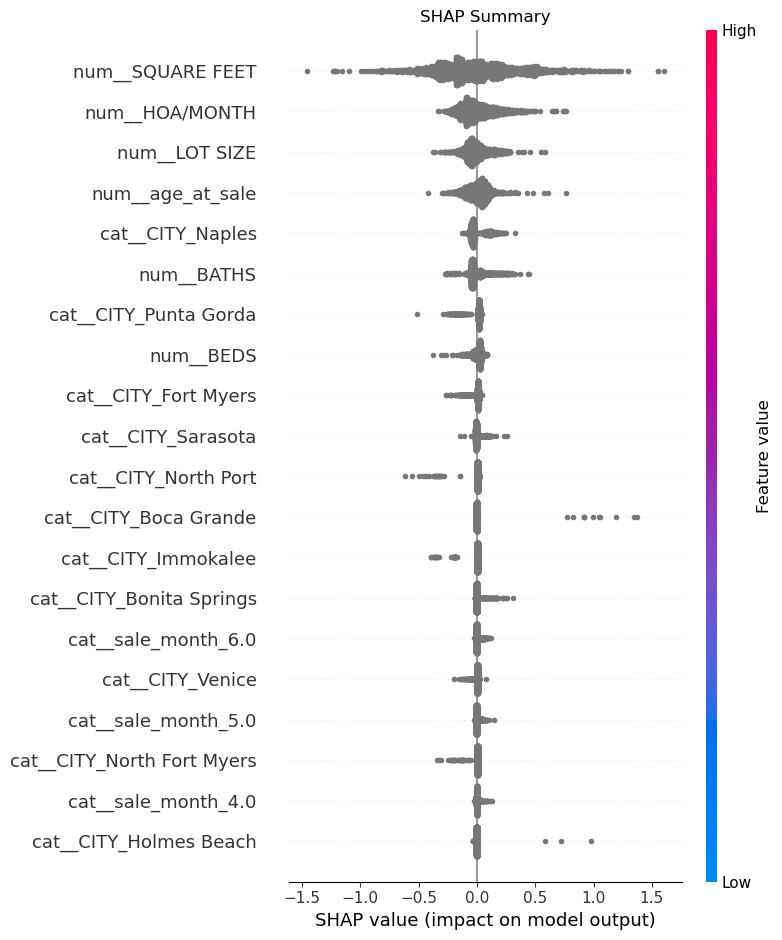

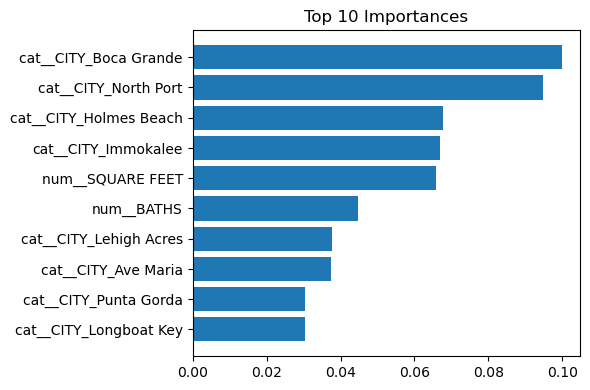

In [30]:
best_xgb   = search_xgb.best_estimator_.named_steps["xgb"]
explainer  = shap.TreeExplainer(best_xgb)
X_tr       = search_xgb.best_estimator_.named_steps["preproc"].transform(X_train)
feat_names = search_xgb.best_estimator_.named_steps["preproc"].get_feature_names_out()

shap_vals  = explainer.shap_values(X_tr[:2000])
plt.figure(figsize=(8,6))
shap.summary_plot(shap_vals, X_tr[:2000], feature_names=feat_names, show=False)
plt.title("SHAP Summary"); plt.tight_layout(); plt.show()

importances = best_xgb.feature_importances_
idx = np.argsort(importances)[-10:]
plt.figure(figsize=(6,4))
plt.barh(feat_names[idx], importances[idx])
plt.title("Top 10 Importances"); plt.tight_layout(); plt.show()


## Ensemble & Residual Analysis  
Blend XGBoost & spline, then inspect residuals.


Ensemble RMSE: 0.450754814955641 MAPE: 0.01675349098481267


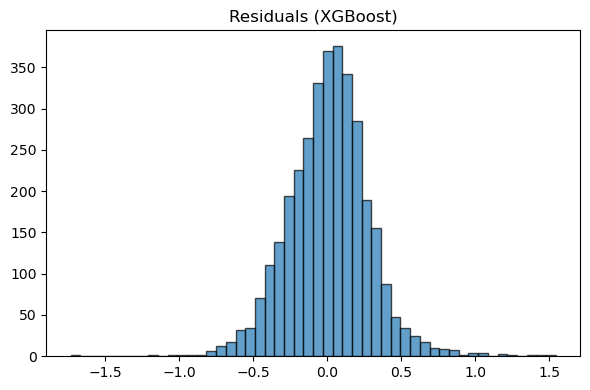

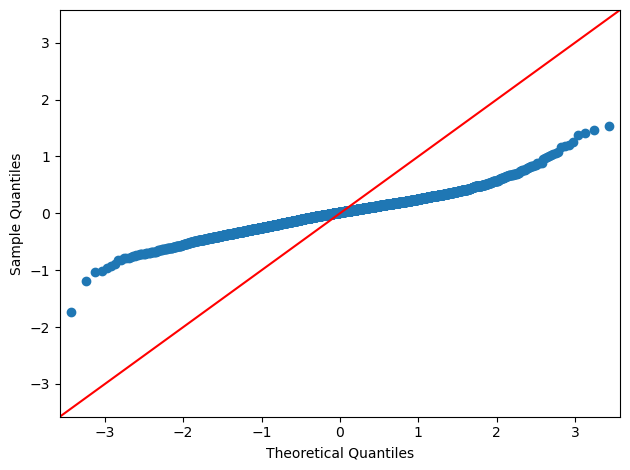

In [32]:
# Ensemble
y_ens = 0.5*y_xgb + 0.5*y_spline
print("Ensemble RMSE:", mean_squared_error(y_test, y_ens, squared=False),
      "MAPE:", mean_absolute_percentage_error(y_test, y_ens))

# Residuals for XGB
resid_xgb = y_test - y_xgb
plt.figure(figsize=(6,4)); plt.hist(resid_xgb, bins=50, edgecolor="black", alpha=0.7)
plt.title("Residuals (XGBoost)"); plt.tight_layout(); plt.show()
sm.qqplot(resid_xgb, line="45"); plt.tight_layout(); plt.show()


## Neural Network (MLP)  
Two‑layer perceptron.


In [34]:
# 1) Define the NN‐specific preprocessor
preproc_nn = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),   # ← strategy keyword
        ("scaler",  StandardScaler())
    ]), numeric_feats),
    ("cat", cat_pipe2, cat_feats)
])

# 2) Build and fit the MLP pipeline
nn_pipe = Pipeline([
    ("preproc", preproc_nn),
    ("mlp",     MLPRegressor(
                    hidden_layer_sizes=(100,50),
                    activation="relu",
                    solver="adam",
                    max_iter=500,
                    random_state=42
               ))
])

nn_pipe.fit(X_train, y_train)

# 3) Evaluate
y_nn = nn_pipe.predict(X_test)
print("NN RMSE:",  mean_squared_error(y_test, y_nn, squared=False))
print("NN MAPE:", mean_absolute_percentage_error(y_test, y_nn))

NN RMSE: 0.33765765633589956
NN MAPE: 0.019334121977025436


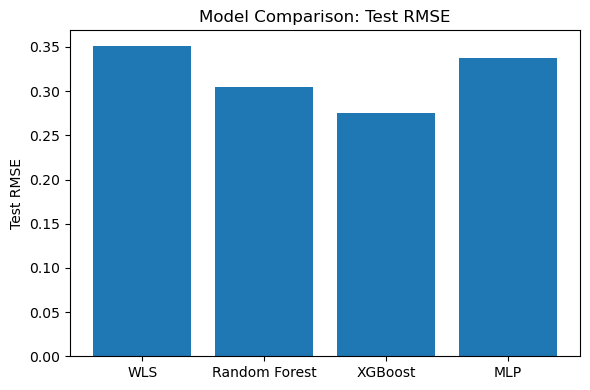

In [35]:
# Compare Test RMSE Across Models

# 1) Compute test‐set RMSE for each model
wls_rmse  = mean_squared_error(y_test,     y_wls_pred, squared=False)
rf_rmse   = mean_squared_error(y_test,     y_rf,       squared=False)
xgb_rmse  = mean_squared_error(y_test,     y_xgb,      squared=False)
nn_rmse   = mean_squared_error(y_test,     y_nn,  squared=False)

models = ["WLS", "Random Forest", "XGBoost", "MLP"]
rmses  = [wls_rmse, rf_rmse, xgb_rmse, nn_rmse]

# 2) Bar chart of RMSE
plt.figure(figsize=(6,4))
plt.bar(models, rmses)
plt.ylabel("Test RMSE")
plt.title("Model Comparison: Test RMSE")
plt.tight_layout()
plt.show()


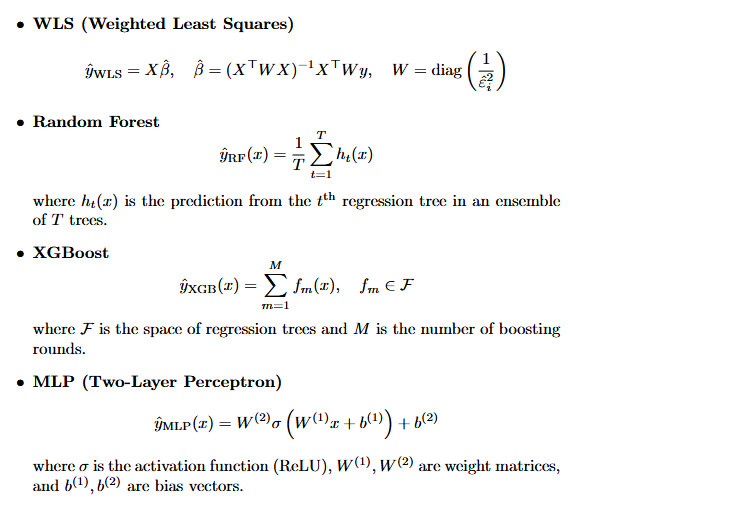

XGBoost: RMSE ≈ 0.275 is the best model

## Time‑Series Forecasting  
- SARIMA on monthly price  
- VAR on price & sales count  
- Forecast vs. actual plots


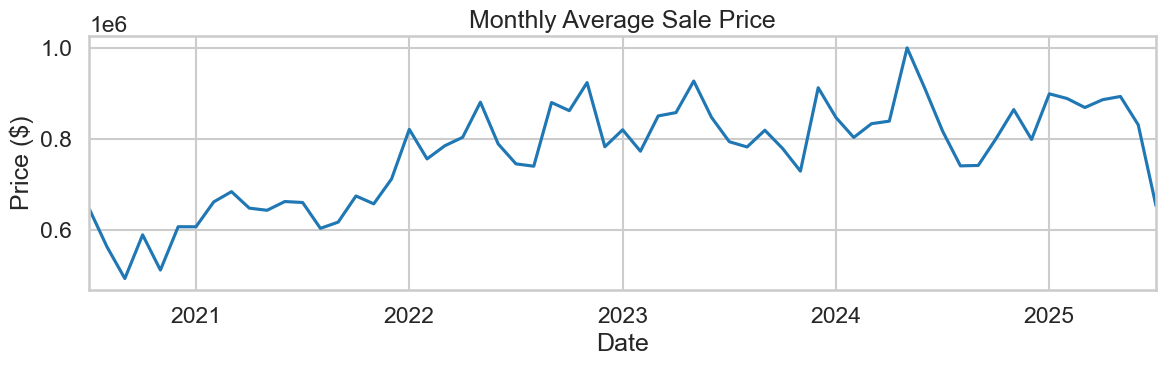

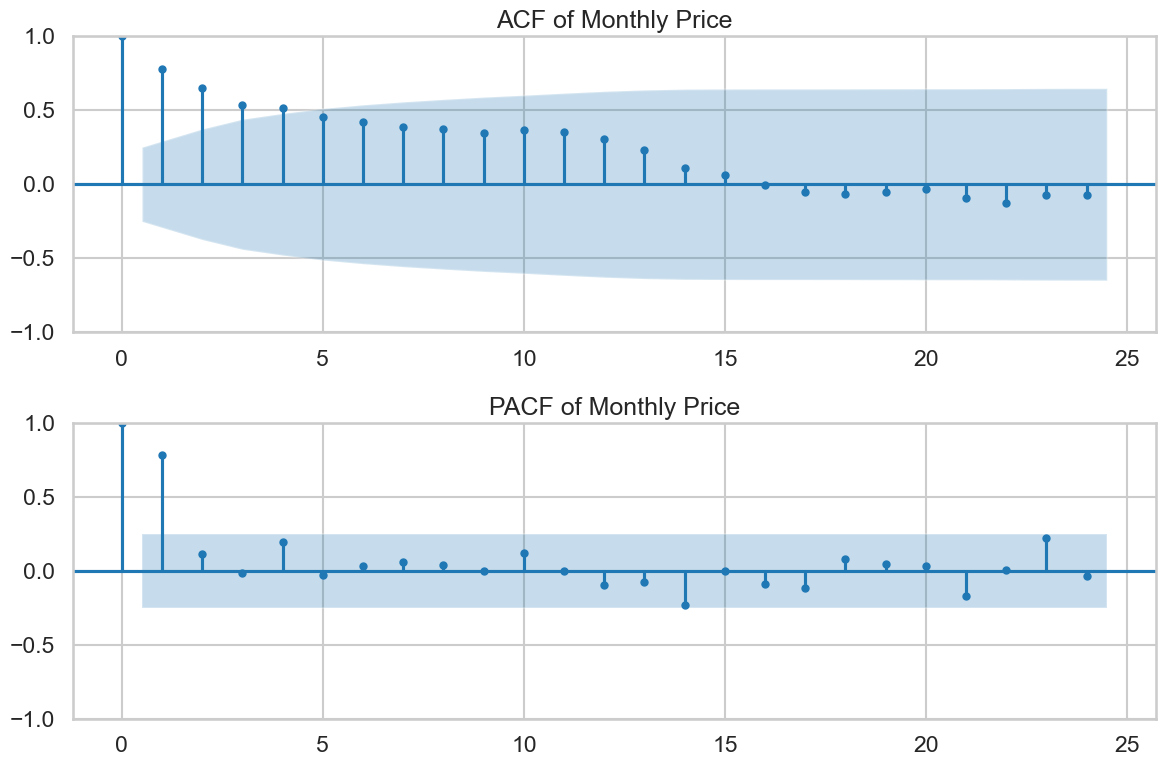

In [100]:
# Cell: Time‑Series EDA (Time plot, ACF & PACF)

# 1) Series plot of monthly average sale price
monthly_price = ts_df["PRICE"]
plt.figure(figsize=(12,4))
monthly_price.plot()
plt.title("Monthly Average Sale Price")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# 2) ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(monthly_price, lags=24, ax=axes[0])
axes[0].set_title("ACF of Monthly Price")
plot_pacf(monthly_price, lags=24, ax=axes[1])
axes[1].set_title("PACF of Monthly Price")
plt.tight_layout()
plt.show()


SARIMA RMSE: 108095.23381140004
VAR RMSE (PRICE): 76128.61320561064


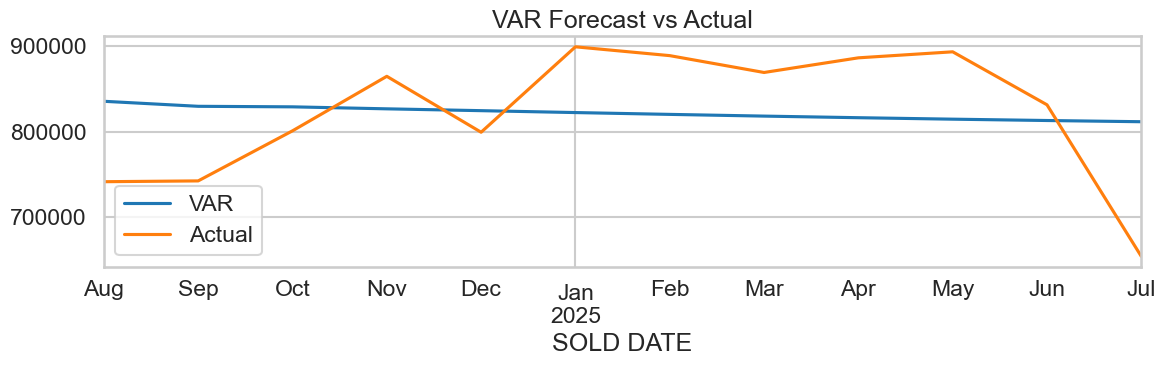

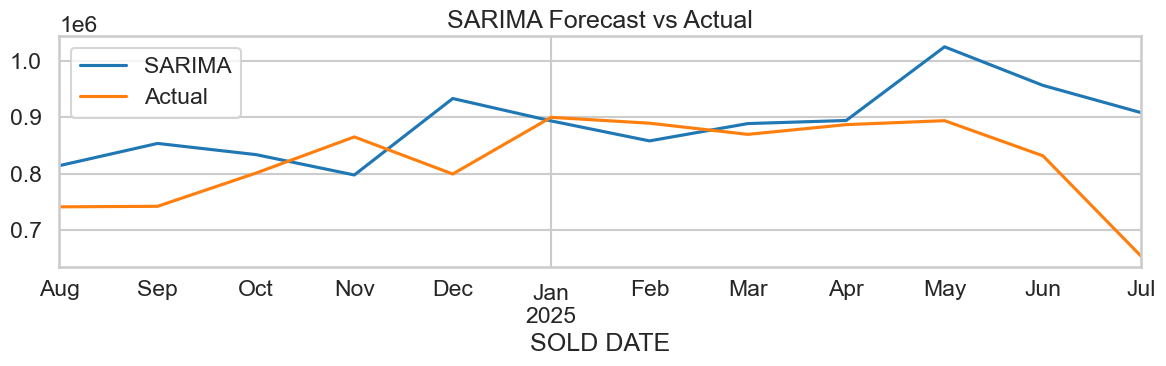

In [98]:
# SARIMA & VAR
ts_df = df.set_index("SOLD DATE").resample("M").agg({"PRICE":"mean","BEDS":"count"}).rename(columns={"BEDS":"SALES_COUNT"})
train_ts, test_ts = ts_df["PRICE"][:-12], ts_df["PRICE"][-12:]

# SARIMA
sarima = SARIMAX(train_ts, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
pred_sar = sarima.get_forecast(steps=12).predicted_mean
print("SARIMA RMSE:", mean_squared_error(test_ts, pred_sar, squared=False))

# VAR
train_var = ts_df[:-12]; test_var = ts_df[-12:]
varm      = VAR(train_var).fit(maxlags=2)
forecast  = varm.forecast(train_var.values[-varm.k_ar:], steps=12)
df_fcast  = pd.DataFrame(forecast, index=test_var.index, columns=train_var.columns)
print("VAR RMSE (PRICE):", mean_squared_error(test_var["PRICE"], df_fcast["PRICE"], squared=False))

# Plot
plt.figure(figsize=(12,4))
df_fcast["PRICE"].plot(label="VAR"); test_var["PRICE"].plot(label="Actual")
plt.legend(); plt.title("VAR Forecast vs Actual"); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,4))
pd.Series(pred_sar, index=test_ts.index).plot(label="SARIMA"); test_ts.plot(label="Actual")
plt.legend(); plt.title("SARIMA Forecast vs Actual"); plt.tight_layout(); plt.show()


**Time Series Model Interpretation**
The average monthly sale price rises overall (2020–2025), with seasonal volatility.

**ACF/PACF:** Strong autocorrelation and slow decay; first-lag PACF dominates (justifies AR/SARIMA/VAR modeling).
- **Forecast accuracy:**  
  - **VAR RMSE:** \$76,129 (best)  
  - **SARIMA RMSE:** \$108,095  
  - VAR more accurately tracks level and dynamics; SARIMA lags on price swings.

**Conclusion:**  
  - VAR outperforms SARIMA—joint modeling of price and sales count improves forecast accuracy for this data.


### **Quantitative Finance Demo: Pricing & Risk on Real Estate Data**

Here I will continue this notebook by the most recent sale price from the cleaned data as the underlying asset in classic quantitative finance routines (option pricing, Monte Carlo risk, bond pricing, and model calibration) to illustrate how real estate prices can be analyzed and risk-managed like traditional financial instruments.

### Black-Scholes-Merton (BSM) Option Pricing

The price of a European call option:
$$
C = S_0 N(d_1) - K e^{-rT} N(d_2)
$$

where
$$
d_1 = \frac{\ln(S_0/K) + \left(r + \frac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}}, \qquad
d_2 = d_1 - \sigma \sqrt{T}
$$

and $S_0$ is the spot price, $K$ the strike, $r$ the risk-free rate, $\sigma$ volatility, $T$ time to maturity, and $N(\cdot)$ the standard normal cdf.

---

### Monte Carlo VaR and CVaR

Given $PL$ as the simulated profit/loss at horizon:
$$
\text{VaR}_\alpha = -\mathrm{Percentile}_{100\times(1-\alpha)}(PL)
$$
$$
\text{CVaR}_\alpha = -\mathbb{E}[PL \mid PL \leq -\text{VaR}_\alpha]
$$

---

### Hull-White Zero Coupon Bond

The price of a zero-coupon bond in the Hull-White model:
$$
P(t, T) = A(t, T) \exp\left( -B(t, T) r_t \right)
$$

where $A(t, T)$ and $B(t, T)$ are functions of model parameters and $r_t$ is the short rate at time $t$.

---

### Heston Stochastic Volatility Model

The variance process:
$$
dv_t = \kappa(\theta - v_t)dt + \sigma \sqrt{v_t} dW_t^2
$$

where $v_t$ is the variance, $\kappa$ mean-reversion, $\theta$ long-run mean, $\sigma$ vol-of-vol, and $W_t^2$ a Wiener process.


In [126]:
# QuantLib demos (fixed calendar)

today = ql.Date(20, ql.July, 2025)
ql.Settings.instance().evaluationDate = today
dc = ql.Actual365Fixed()

# Flat curves
spot_q = ql.SimpleQuote(df["PRICE"].iloc[-1])
spot_h = ql.QuoteHandle(spot_q)
r_flat, q_flat, vol_flat = 0.03, 0.01, 0.25

rf_ts  = ql.YieldTermStructureHandle(ql.FlatForward(today, r_flat, dc))
div_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, q_flat, dc))

# -- Fix: supply the required 'm' argument for UnitedStates calendar --
cal    = ql.UnitedStates(ql.UnitedStates.GovernmentBond)

vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(today, cal, vol_flat, dc)
)

# BSM Call
bsm = ql.VanillaOption(
    ql.PlainVanillaPayoff(ql.Option.Call, 105.0),
    ql.EuropeanExercise(today + ql.Period(6, ql.Months))
)
bsm.setPricingEngine(
    ql.AnalyticEuropeanEngine(
        ql.BlackScholesMertonProcess(spot_h, div_ts, rf_ts, vol_ts)
    )
)
print("BSM NPV:", bsm.NPV(), 
      "Delta:", bsm.delta(), 
      "Gamma:", bsm.gamma(), 
      "Vega:", bsm.vega())

# Monte‑Carlo VaR/CVaR
np.random.seed(42)
S0, T, sigma = 100.0, 1.0, vol_flat
r, q = r_flat, q_flat
N_steps, N_sims = 252, 200_000
dt = T/N_steps
paths = np.empty((N_sims, N_steps+1)); paths[:,0] = S0
drift = (r - q - 0.5*sigma**2)*dt; diff = sigma*np.sqrt(dt)
for t in range(1, N_steps+1):
    z = np.random.randn(N_sims)
    paths[:,t] = paths[:,t-1] * np.exp(drift + diff*z)
ST = paths[:,-1]; PL = ST - S0*np.exp(r*T)
VaR95  = -np.percentile(PL, 5)
CVaR95 = -PL[PL <= np.percentile(PL, 5)].mean()
print("VaR95:", VaR95, "CVaR95:", CVaR95)

# Hull–White ZCB
hw = ql.HullWhite(rf_ts, 0.1, 0.01)
zcb = ql.ZeroCouponBond(
    0, 
    cal, 
    100.0, 
    today + ql.Period(5, ql.Years), 
    ql.Following
)
zcb.setPricingEngine(ql.DiscountingBondEngine(rf_ts))
print("HW ZCB NPV:", zcb.NPV())

# Heston calibration
helpers = []
for m in [ql.Period(1, ql.Months), ql.Period(6, ql.Months)]:
    for k in [90, 100, 110]:
        helpers.append(
            ql.HestonModelHelper(
                m, cal, spot_q.value(), k,
                ql.QuoteHandle(ql.SimpleQuote(0.25)),
                rf_ts, div_ts
            )
        )
process_heston = ql.HestonProcess(
    rf_ts, div_ts, spot_h,
    0.04, 1.0, 0.04, 0.2, 0.0
)
model_heston  = ql.HestonModel(process_heston)
engine_heston = ql.AnalyticHestonEngine(model_heston)
for h in helpers:
    h.setPricingEngine(engine_heston)

model_heston.calibrate(
    helpers,
    ql.LevenbergMarquardt(),
    ql.EndCriteria(1000, 50, 1e-8, 1e-8, 1e-8)
)
print("Calibrated Heston params:", model_heston.params())


BSM NPV: 716276.1201565787 Delta: 0.9949715891090926 Gamma: 0.0 Vega: 0.0
VaR95: 37.467717656918346 CVaR95: 43.671836614423235
HW ZCB NPV: 86.04957732241215
Calibrated Heston params: [ 0.04; 1; 0.2; 0; 0.04 ]


#### Interpretation

- The option, bond, and risk metrics are calculated as if the real estate price were a tradable asset.
- Results demonstrate pricing, sensitivity (Greeks), risk (VaR/CVaR), and model calibration using real Southwest Florida housing data.
- This illustrates how quant finance tools can be applied to non-traditional markets for risk management or product innovation.
